# [exp_09]: Feature Detection with SIFT and ORB on gray image

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.metrics import confusion_matrix

(485, 857)


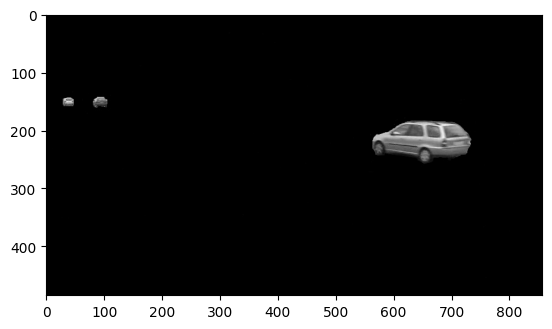

In [9]:
img = cv.imread("../dataset/frames/train/video29/00029_1640_flip.jpg")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_ground_truth_gray = cv.imread('../experiments/img/ground_truth_image_gray.jpg',0)

print(img_gray.shape)
plt.imshow(img_ground_truth_gray, cmap='gray')

In [8]:
# resizing_percentages = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
# def mysize(image):
#     result = []
#     for percentage in resizing_percentages:
#         new_width = int(image.shape[1] * percentage)
#         new_height = int(image.shape[0] * percentage)

#         resized_img = cv.resize(image, (new_width, new_height))
#         resized_img_ground_truth = cv.resize(img_ground_truth_gray, (new_width, new_height))
#         corrcof = np.corrcoef(resized_img.flatten(), resized_img_ground_truth.flatten())[0,1]
#         print(corrcof)

# img_1 = cv.imread('../experiments/img/09/00011_9560-1.jpg')
# img_2 = cv.imread('../experiments/img/09/00014_9200-2.jpg')
# img_3 = cv.imread('../experiments/img/09/00021_8440-3.jpg')
# img_4 = cv.imread('../experiments/img/09/00024_8560-4.jpg')
# img_5 = cv.imread('../experiments/img/09/00025_8880-5.jpg')

# li = [img_1,img_2,img_3,img_4,img_5,img_gray]
# df_sizing = pd.DataFrame(resizing_percentages)

# for i in li:
#     result = mysize(i)
    

0.2 0.036453731636779334
0.3 0.03632771223054827
0.4 0.038174526392542624
0.5 0.0381444689590813
0.6 0.03821542265195994
0.7 0.037483875290994194
0.8 0.038068574140878296
0.9 0.037703087420845056
1.0 0.0400560616759338
1.1 0.03806097748080873
1.2 0.03796079474967646


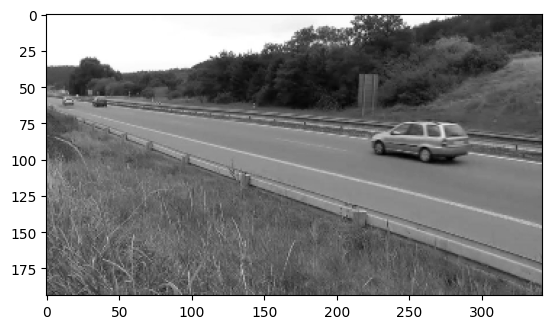

In [10]:
def mysize(image):
    resizing_percentages = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

    for percentage in resizing_percentages:
        new_width = int(image.shape[1] * percentage)
        new_height = int(image.shape[0] * percentage)

        resized_img = cv.resize(image, (new_width, new_height))
        resized_img_ground_truth = cv.resize(img_ground_truth_gray, (new_width, new_height))
        corrcof = np.corrcoef(resized_img.flatten(), resized_img_ground_truth.flatten())[0,1]
        print(percentage, corrcof)

mysize(img_gray)

img_gray = cv.resize(img_gray, (int(img_gray.shape[1] * 0.4), int(img_gray.shape[0] * 0.4)))
# img_mexican_hat = cv.resize(img_mexican_hat, (int(img_mexican_hat.shape[1] * 0.4), int(img_mexican_hat.shape[0] * 0.4)))
img_ground_truth_gray = cv.resize(img_ground_truth_gray, (int(img_ground_truth_gray.shape[1] * 0.4), int(img_ground_truth_gray.shape[0] * 0.4)))
plt.imshow(img_gray,cmap='gray')

In [11]:
def img_to_canny_edges(img, kernel_size=(3,3)):
    img_blur = cv.blur(img, kernel_size)
    img_med = int(np.median(img_blur))
    img_med_lower = int(max(0, 0.7 * img_med))
    img_med_upper = int(min(255, 1.3 * img_med))
    img_canny = cv.Canny(img_blur, img_med_lower, img_med_upper)
    return img_canny

def img_to_mexican_hat_edges(img, kernel_size=3):
    sobel_x = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=kernel_size)
    img_mexican_hat = cv.magnitude(sobel_x, sobel_y)
    return img_mexican_hat

def img_to_hanny_edges(img, kernel_size=(3,3)):
    img_hanny = cv.Laplacian(cv.GaussianBlur(img, kernel_size, 0), cv.CV_64F) + 128
    return img_hanny

def img_to_prewitt_edges(img,kernel_size=(3,3)):
    img_blur = cv.blur(img, kernel_size)
    kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    img_prewittx = cv.filter2D(img_blur, cv.CV_64F, kernelx)
    img_prewitty = cv.filter2D(img_blur, cv.CV_64F, kernely)
    img_prewitt = cv.magnitude(img_prewittx, img_prewitty)
    return img_prewitt

def img_to_rebert_cross_edges(img,kernel_size=(3,3)):
    img_blur = cv.blur(img, kernel_size)
    roberts_x = np.array([[1, 0], [0, -1]], dtype=np.float32)
    roberts_y = np.array([[0, 1], [-1, 0]], dtype=np.float32)   
    roberts_x_edge = cv.filter2D(img_blur, cv.CV_64F, roberts_x)
    roberts_y_edge = cv.filter2D(img_blur, cv.CV_64F, roberts_y)
    img_roberts = cv.magnitude(roberts_x_edge, roberts_y_edge)
    return img_roberts

def img_to_frei_chen_edges(img,kernel_size=(3,3)):
    img_blur = cv.blur(img, kernel_size)
    frei_chen_x = np.array([[1, np.sqrt(2), 1], [0, 0, 0], [-1, -np.sqrt(2), -1]], dtype=np.float32)
    frei_chen_y = np.array([[-1, 0, 1], [-np.sqrt(2), 0, np.sqrt(2)], [-1, 0, 1]], dtype=np.float32)    
    frei_chen_x_edge = cv.filter2D(img_blur, cv.CV_64F, frei_chen_x)
    frei_chen_y_edge = cv.filter2D(img_blur, cv.CV_64F, frei_chen_y)
    img_frei_chen = cv.magnitude(frei_chen_x_edge, frei_chen_y_edge)
    return img_frei_chen

def img_to_cragis_edges(img,kernel_size=(3,3)):
    image_blur = cv.GaussianBlur(img,kernel_size, 0)
    craigs_x = cv.Sobel(image_blur, cv.CV_64F, 1, 0, ksize=3)
    craigs_y = cv.Sobel(image_blur, cv.CV_64F, 0, 1, ksize=3)
    img_craigs = cv.magnitude(craigs_x, craigs_y)
    return img_craigs

Text(0.5, 1.0, 'img_gray')

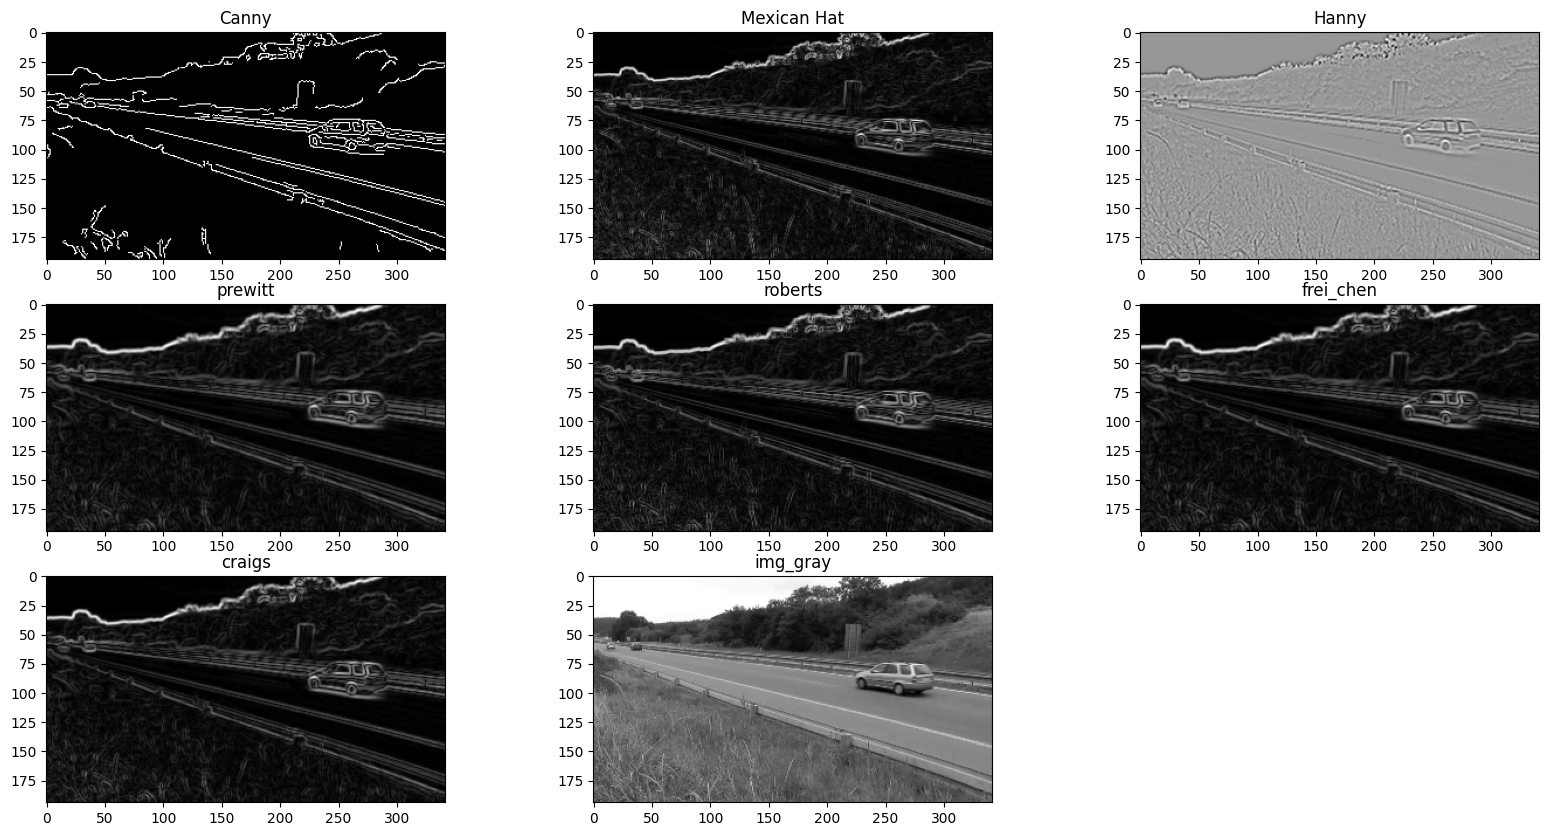

In [12]:
img_canny = img_to_canny_edges(img_gray)
img_mexican_hat = img_to_mexican_hat_edges(img_gray)
img_hanny = img_to_hanny_edges(img_gray)
img_prewitt = img_to_prewitt_edges(img_gray)
img_roberts = img_to_rebert_cross_edges(img_gray)
img_frei_chen = img_to_frei_chen_edges(img_gray)
img_craigs = img_to_cragis_edges(img_gray)

# cv.imshow('canny',img_canny)
# cv.imshow('mexican-hat',img_mexican_hat)
# cv.imshow('hanny',img_hanny)
# cv.waitKey(0)
# cv.destroyAllWindows()
plt.figure(figsize=(20,10))

plt.subplot(3,3,1)
plt.imshow(img_canny,cmap='gray')
plt.title('Canny')

plt.subplot(3,3,2)
plt.imshow(img_mexican_hat,cmap='gray')
plt.title('Mexican Hat')

plt.subplot(3,3,3)
plt.imshow(img_hanny,cmap='gray')
plt.title('Hanny')

plt.subplot(3,3,4)
plt.imshow(img_prewitt,cmap='gray')
plt.title('prewitt')

plt.subplot(3,3,5)
plt.imshow(img_roberts,cmap='gray')
plt.title('roberts')

plt.subplot(3,3,6)
plt.imshow(img_frei_chen,cmap='gray')
plt.title('frei_chen')

plt.subplot(3,3,7)
plt.imshow(img_craigs,cmap='gray')
plt.title('craigs')

plt.subplot(3,3,8)
plt.imshow(img_gray,cmap='gray')
plt.title('img_gray')

# correlation coeficient

In [13]:
corrcof_canny = np.corrcoef(img_canny.flatten(), img_ground_truth_gray.flatten())[0,1]
corrcof_sobel = np.corrcoef(img_mexican_hat.flatten(), img_ground_truth_gray.flatten())[0,1]
corrcof_hanny = np.corrcoef(img_hanny.flatten(), img_ground_truth_gray.flatten())[0,1]
corrcof_prewitt = np.corrcoef(img_prewitt.flatten(), img_ground_truth_gray.flatten())[0,1]
corrcof_roberts = np.corrcoef(img_roberts.flatten(), img_ground_truth_gray.flatten())[0,1]
corrcof_frei_chen = np.corrcoef(img_frei_chen.flatten(), img_ground_truth_gray.flatten())[0,1]
corrcof_cragis = np.corrcoef(img_craigs.flatten(), img_ground_truth_gray.flatten())[0,1]

print(corrcof_canny,corrcof_sobel,corrcof_hanny,corrcof_prewitt,corrcof_roberts,corrcof_frei_chen,corrcof_cragis)

0.13149342487052326 0.2256728525106275 -0.1038775312838909 0.2091608496332815 0.22466727067114273 0.2092673416528364 0.21525011525928217


# evaluate kernel size

In [14]:
kernel_sizes = [num for num in range(1, 32) if num % 2 != 0]
results_df = pd.DataFrame(columns=['Kernel Size', 'Canny', 'Mexican Hat', 'Hanny', 'Prewitt', 'Roberts', 'Frei-Chen', 'Craigs'])

# img_blur = cv.blur(img_gray, (3,3))
for kernel_size in kernel_sizes:
    
    img_canny_kernel = img_to_canny_edges(img_gray,(kernel_size,kernel_size))
    corrcof_canny = np.corrcoef(img_canny_kernel.flatten(), img_ground_truth_gray.flatten())[0,1]

    img_mexican_hat_kernel = img_to_mexican_hat_edges(img_gray,(kernel_size))
    corrcof_mexican_hat = np.corrcoef(img_mexican_hat_kernel.flatten(), img_ground_truth_gray.flatten())[0,1]

    img_hanny_kernel = img_to_hanny_edges(img_gray,(kernel_size,kernel_size))
    corrcof_hanny = np.corrcoef(img_hanny_kernel.flatten(), img_ground_truth_gray.flatten())[0,1]
    
    img_prewitt_kernel = img_to_prewitt_edges(img_gray,(kernel_size,kernel_size))
    corrcof_prewitt = np.corrcoef(img_prewitt_kernel.flatten(), img_ground_truth_gray.flatten())[0,1]

    img_roberts_kernel = img_to_rebert_cross_edges(img_gray,(kernel_size,kernel_size))
    corrcof_roberts = np.corrcoef(img_roberts_kernel.flatten(), img_ground_truth_gray.flatten())[0,1]

    img_frei_chen_kernel = img_to_frei_chen_edges(img_gray,(kernel_size,kernel_size))
    corrcof_frei_chen = np.corrcoef(img_frei_chen_kernel.flatten(), img_ground_truth_gray.flatten())[0,1]

    img_craigs_kernel = img_to_cragis_edges(img_gray,(kernel_size,kernel_size))
    corrcof_craigs = np.corrcoef(img_craigs_kernel.flatten(), img_ground_truth_gray.flatten())[0,1]
    
    results_df.loc[len(results_df)] = [kernel_size, corrcof_canny, corrcof_mexican_hat, corrcof_hanny, corrcof_prewitt, corrcof_roberts, corrcof_frei_chen, corrcof_craigs]

results_df
    
    # plt.figure(figsize=(10,8))
    # plt.imshow(detected_edges,cmap='gray')
    # plt.title(f"figure with size : {kernel_size}")

c:\Users\shakr\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\shakr\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\shakr\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\shakr\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\shakr\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\shakr\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_bas

,Kernel Size,Canny,Mexican Hat,Hanny,Prewitt,Roberts,Frei-Chen,Craigs
0,1.0,0.067971,0.200246,-0.060791,0.228600,0.204470,0.227607,0.225673
1,3.0,0.131493,0.225673,-0.103878,0.209161,0.224667,0.209267,0.215250
2,5.0,0.162372,0.215493,-0.113976,0.165682,0.179523,0.165942,0.200206
3,7.0,0.152393,0.200345,-0.117802,0.133828,0.141727,0.133934,0.175082
4,9.0,-0.010724,0.185985,-0.112121,0.101207,0.107614,0.101307,0.159056
5,11.0,-0.010816,0.173902,-0.106421,0.084925,0.090398,0.085006,0.141992
6,13.0,-0.009120,0.163871,-0.092189,0.077857,0.080872,0.077890,0.124620
7,15.0,-0.007392,0.155039,-0.083608,0.070221,0.072195,0.070243,0.110684
8,17.0,NaN,0.147043,-0.074438,0.065153,0.066328,0.065178,0.099045
9,19.0,NaN,0.139726,-0.061182,0.054302,0.055471,0.054322,0.088096


# rescale the image

In [15]:
# def mysize(image):
#     resizing_percentages = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

#     for percentage in resizing_percentages:
#         new_width = int(image.shape[1] * percentage)
#         new_height = int(image.shape[0] * percentage)

#         resized_img = cv.resize(image, (new_width, new_height))
#         resized_img_ground_truth = cv.resize(img_ground_truth_gray, (new_width, new_height))
#         corrcof = np.corrcoef(resized_img.flatten(), resized_img_ground_truth.flatten())[0,1]
#         print(percentage, corrcof)

# mysize(img_mexican_hat)

# print(np.unique(img_mexican_hat))
# img_gray = cv.resize(img_gray, (int(img_gray.shape[1] * 0.4), int(img_gray.shape[0] * 0.4)))
# img_mexican_hat = cv.resize(img_mexican_hat, (int(img_mexican_hat.shape[1] * 0.4), int(img_mexican_hat.shape[0] * 0.4)))
# img_ground_truth_gray = cv.resize(img_ground_truth_gray, (int(img_ground_truth_gray.shape[1] * 0.4), int(img_ground_truth_gray.shape[0] * 0.4)))
# plt.imshow(img_mexican_hat,cmap='gray')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 234
 235 236 237 240 241 242 243 245 247 250 251 253 25

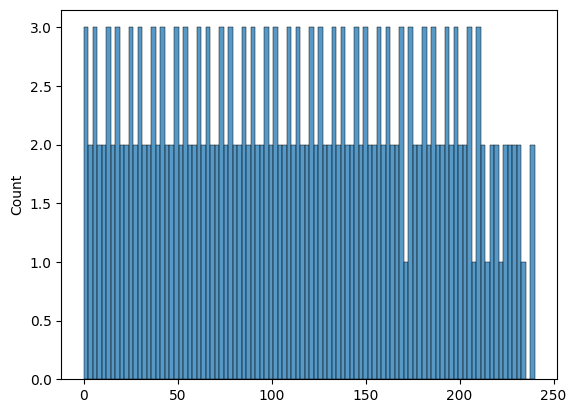

In [16]:
img_mexican_hat = cv.normalize(img_mexican_hat, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
sns.histplot(x=np.unique(img_ground_truth_gray),bins=100)
_, binary_thresholded_image = cv.threshold(img_mexican_hat, 80, 255, cv.THRESH_BINARY)
# plt.imshow(binary_thresholded_image,cmap='gray')
print(np.unique(img_mexican_hat))

# Feature Matching

accuracy: 1.57%
Confusion Matrix:
[[28  5]
 [ 5  0]]
All Truth Keypoints 38
All Estimated Keypoints 318


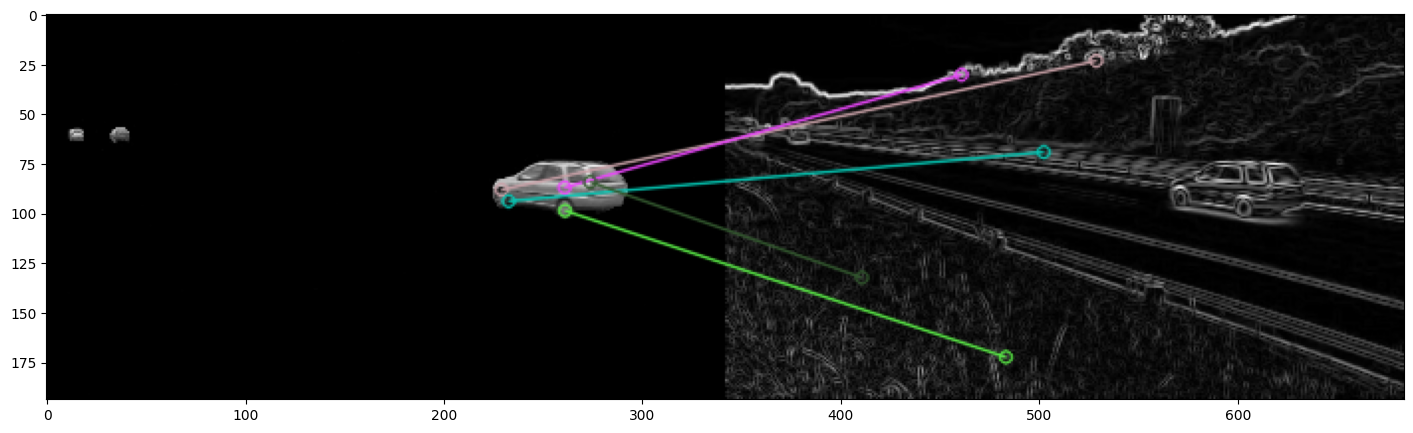

In [25]:
# feature detection
sift = cv.SIFT_create()

keypoints_gray, descriptors_gray = sift.detectAndCompute(img_ground_truth_gray, None)
keypoints_edge, descriptors_edge = sift.detectAndCompute(img_mexican_hat, None)

# object matching
bf = cv.BFMatcher()

matches = bf.knnMatch(descriptors_gray, descriptors_edge, k=2)

good_matches = []
total_correct = 0
for m, n in matches:
    if m.distance < 0.9 * n.distance: # if m distance (indicate to descripter to the grd_img) is less than 0.5 * n distance (indicate to descripter of the estimate_img) then it may belong to the object else it belong to the background
        good_matches.append(m)
        total_correct += 1

img_matches = cv.drawMatches(img_ground_truth_gray, keypoints_gray, img_mexican_hat, keypoints_edge, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

ground_truth_keypoints = total_correct
predicted_keypoints = len(keypoints_edge)

ground_truth_labels = np.zeros(len(matches))
predicted_labels = np.zeros(len(matches))
for i, match in enumerate(matches):
    if i in [m.queryIdx for m in good_matches]:  # check if the index is in good_matches
        predicted_labels[i] = 1
    if i < len(good_matches):
        ground_truth_labels[i] = 1

conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels)

print(f"accuracy: {ground_truth_keypoints / predicted_keypoints :.2%}")
print("Confusion Matrix:")
print(conf_matrix)
print("All Truth Keypoints", len(keypoints_gray))
print("All Estimated Keypoints", len(keypoints_edge))
plt.figure(figsize=(20,5))
plt.imshow(img_matches)

accuracy: 53.26%
Confusion Matrix:
[[143  27]
 [ 27   7]]
All Truth Keypoints 204
All Estimated Keypoints 383


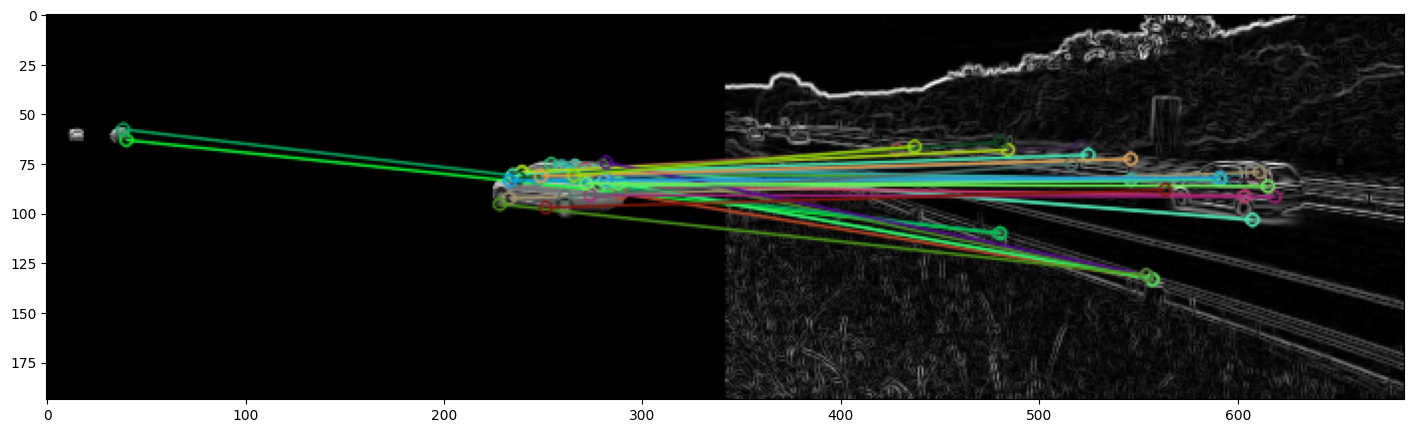

In [23]:
# feature detection

orb = cv.ORB_create()

keypoints_gray, descriptors_gray = orb.detectAndCompute(img_ground_truth_gray, None)
keypoints_edge, descriptors_edge = orb.detectAndCompute(img_mexican_hat, None)

# object matching
bf = cv.BFMatcher()

matches = bf.knnMatch(descriptors_gray, descriptors_edge, k=2)

good_matches = []
total_correct = 0
for m, n in matches:
    if m.distance < 0.9 * n.distance:
        good_matches.append(m)
        total_correct += 1

img_matches = cv.drawMatches(img_ground_truth_gray, keypoints_gray, img_mexican_hat, keypoints_edge, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

ground_truth_labels = np.zeros(len(matches))
predicted_labels = np.zeros(len(matches))
for i, match in enumerate(matches):
    if i in [m.queryIdx for m in good_matches]:  # check if the index is in good_matches
        predicted_labels[i] = 1
    if i < len(good_matches):
        ground_truth_labels[i] = 1

conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels)

print(f"accuracy: {ground_truth_keypoints / predicted_keypoints :.2%}")
print("Confusion Matrix:")
print(conf_matrix)
print("All Truth Keypoints", len(keypoints_gray))
print("All Estimated Keypoints", len(keypoints_edge))
plt.figure(figsize=(20,5))
plt.imshow(img_matches)

You use the matcher.match() method to find the matches between the descriptors of the two sets of keypoints. 
This method returns a list of matches where each match contains information about the corresponding keypoints in the two sets and the distance between their descriptors.

Optionally, you can perform k-nearest neighbors (KNN) search instead of simple matching. This is achieved by using the matcher.knnMatch() method. In this case, for each descriptor in the first set, the knnMatch() method finds the k nearest neighbors in the second set of descriptors.

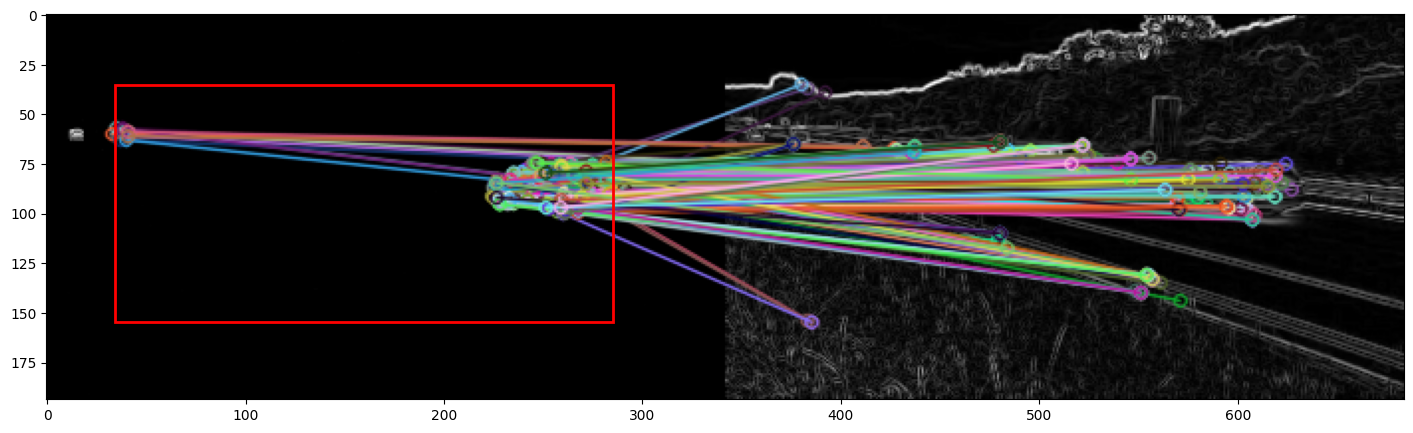

In [19]:
sourse_points = []
distination_points = []

for match in good_matches:
    sourse_points.append(keypoints_gray[match.queryIdx].pt)
    distination_points.append(keypoints_edge[match.trainIdx].pt)

src_pts = np.float32(sourse_points).reshape(-1, 1, 2)
dst_pts = np.float32(distination_points).reshape(-1, 1, 2)

x_min = min([pt[0][0] for pt in dst_pts])
x_max = max([pt[0][0] for pt in dst_pts])
y_min = min([pt[0][1] for pt in dst_pts])
y_max = max([pt[0][1] for pt in dst_pts])

rectangle = Rectangle((x_min, y_min), (x_max - x_min), (y_max - y_min), linewidth=2, edgecolor='r', facecolor='none')

fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(img_matches, cmap='gray')
ax.add_patch(rectangle)

# fig, ax = plt.subplots(figsize=(20, 5))
# ax.imshow(img_matches, cmap='gray')

# # Iterate over each point in dst_pts
# for pt in dst_pts:
#     x, y = pt[0]
#     # Define the width and height of the rectangle (adjust as needed)
#     rect_width = 10
#     rect_height = 10
#     # Calculate the coordinates of the top-left corner of the rectangle
#     x_min = x - rect_width / 2
#     y_min = y - rect_height / 2
#     # Create and add the rectangle patch to the plot
#     rectangle = Rectangle((x_min, y_min), rect_width, rect_height, linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rectangle)

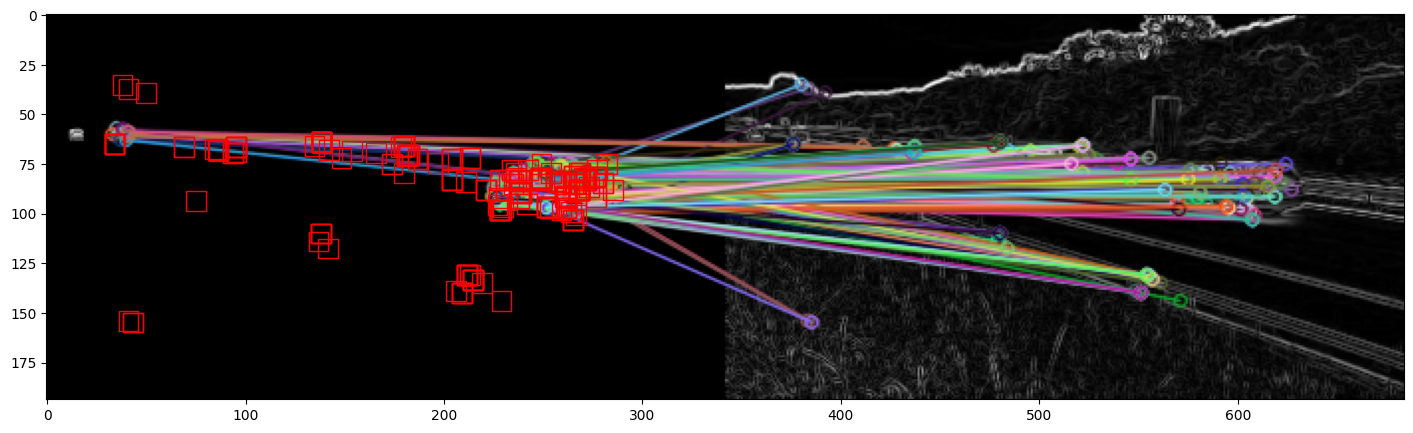

In [20]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(img_matches, cmap='gray')

for pt in dst_pts:
    x, y = pt[0]
    
    rect_width = 10
    rect_height = 10
    
    x_min = x - rect_width / 2
    y_min = y - rect_height / 2
    
    rectangle = Rectangle((x_min, y_min), rect_width, rect_height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rectangle)

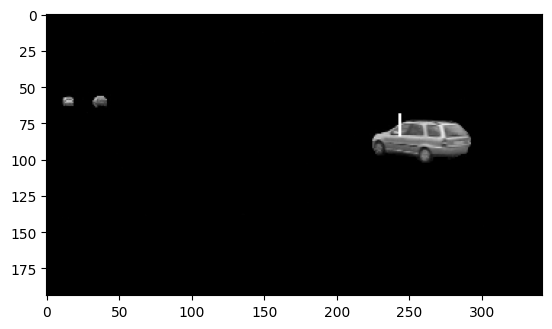

In [21]:

homography, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC)

h, w = img_mexican_hat.shape[:2]
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
transformed_pts = cv.perspectiveTransform(pts, homography)
min_x, min_y = np.int32(transformed_pts.min(axis=0).ravel())
max_x, max_y = np.int32(transformed_pts.max(axis=0).ravel())

result_image = img_ground_truth_gray.copy()
rectangle = cv.rectangle(result_image, (min_x, min_y), (max_x, max_y), (255, 255, 255), 1)

plt.imshow(rectangle ,cmap='gray')